In [2]:
!pip install scikeras

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       691
           1       1.00      1.00      1.00        63

    accuracy                           1.00       754
   macro avg       1.00      1.00      1.00       754
weighted avg       1.00      1.00      1.00       754



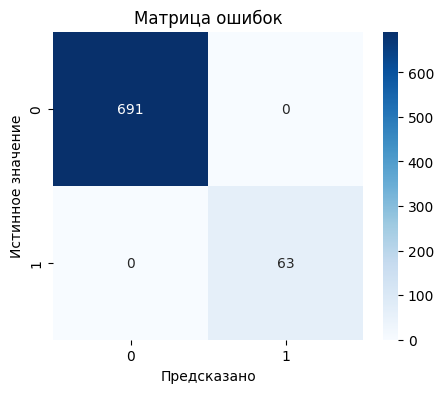

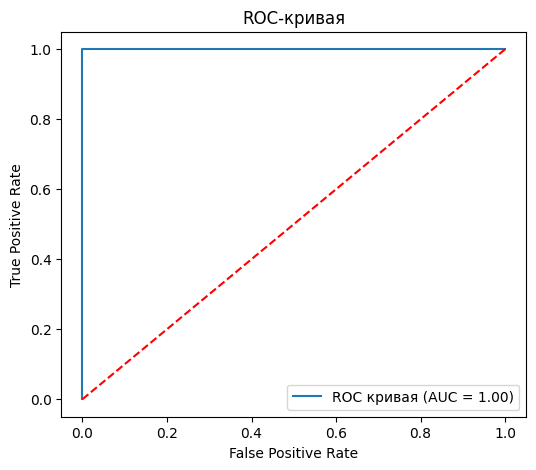

Всего транзакций: 2512
Мошеннических транзакций: 221
Доля мошенничества: 8.80%


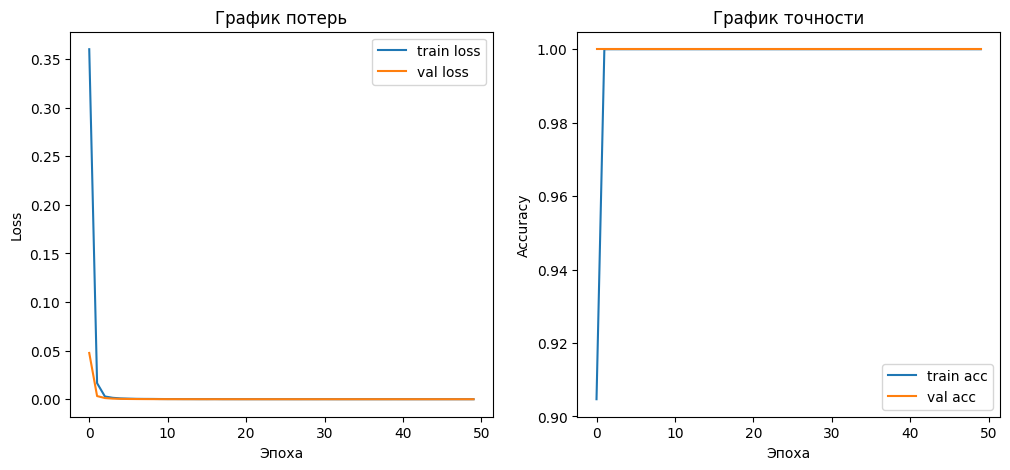

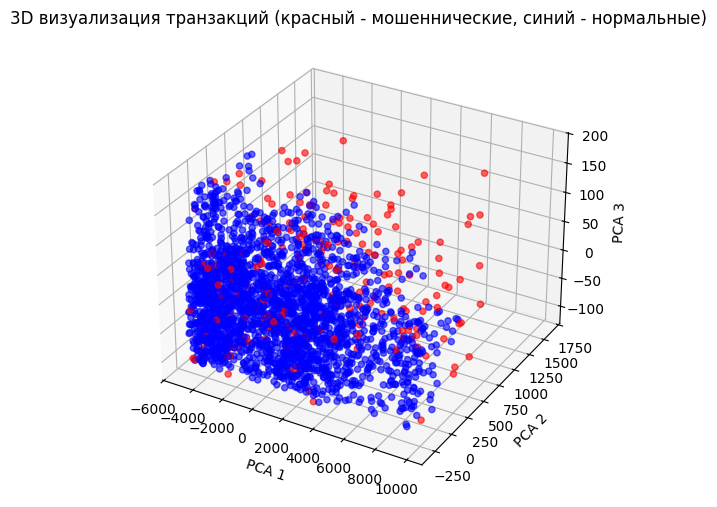

In [6]:
# Импорт необходимых библиотек
import io
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Для 3D графика
from mpl_toolkits.mplot3d import Axes3D

# Машинное обучение и кластеризация
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.impute import KNNImputer

# Для редукции размерностей (3D визуализация)
from sklearn.decomposition import PCA

# Импорт TensorFlow/Keras для модели с эпохами обучения
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

# Импорт виджетов для интерфейса в Google Colab
import ipywidgets as widgets
from IPython.display import display, clear_output

# Глобальное состояние для хранения датасета, модели и истории обучения
global_state = {
    "df_raw": None,
    "df_processed": None,
    "model": None,
    "history": None,
    "X_test": None,
    "y_test": None
}

#########################################
# Виджет для загрузки датасета (*.csv)  #
#########################################
upload_widget = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description="Загрузить датасет"
)

def load_data(file_info):
    """Загружает данные из CSV-файла, используя содержимое файла.
    Аргументы:
    file_info (dict): Информация о файле, содержащая ключ 'content' с содержимым файла.
    Возвращает:
    pandas.DataFrame: DataFrame с данными или None в случае ошибки.
    """
    try:
        content = file_info['content']
        df = pd.read_csv(io.BytesIO(content))
        print(f"Датасет успешно загружен. Размер: {df.shape}")
        return df
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None

def on_upload_change(change):
    clear_output(wait=True)
    if upload_widget.value:
        # Получаем имя файла и контент
        for fname, file_info in upload_widget.value.items():
            df = load_data(file_info)
            if df is not None:
                global_state["df_raw"] = df.copy()
                print(f"Датасет '{fname}' успешно загружен. Размер: {df.shape}")
    display(ui)

upload_widget.observe(on_upload_change, names='value')

#######################################################
# Кнопка: Предобработка и анонимизация датасета         #
#######################################################
preprocess_button = widgets.Button(
    description="Предобработка датасета",
    button_style='info'
)

def preprocess_data(df):
    """Предобрабатывает DataFrame, анонимизирует данные и обрабатывает пропуски.
    Аргументы:
        df (pandas.DataFrame): Исходный DataFrame.
    Возвращает:
        pandas.DataFrame: Предобработанный DataFrame.
    """
    print("Начинается предобработка...")

    # Анонимизация: удаляем или скрываем столбцы, раскрывающие личную информацию
    for col in ["IP Address", "Location"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
            print(f"Столбец '{col}' удалён для анонимизации.")

    # Простейшая очистка: удаляем дубликаты
    df.drop_duplicates(inplace=True)

    # Обработка пропусков: используем KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Выбираем числовые колонки для кластеризации
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Если датасет содержит менее одного числового признака – предупреждаем
    if len(numeric_cols) < 2:
        print("Недостаточно числовых признаков для кластеризации.")
        return df

    # Стандартизация числовых признаков для DBSCAN
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[numeric_cols])

    # Применяем DBSCAN для выявления аномалий
    dbscan = DBSCAN(eps=0.7, min_samples=5) #------------------------------------------------------------------
    clusters = dbscan.fit_predict(scaled_features)
    df["cluster"] = clusters

    # Предполагаем, что транзакции с меткой -1 являются аномальными (мошенническими)
    df["isFraud"] = df["cluster"].apply(lambda x: 1 if x == -1 else 0)

    print(f"Предобработка завершена. Обнаружено мошеннических транзакций: {df['isFraud'].sum()}")

    # Вывод первых 5 строк предобработанного датасета с отображением столбца isFraud
    print("Пример первых 5 строк предобработанного датасета:")
    display(df.head(5))

    return df

def on_preprocess_clicked(b):
    clear_output(wait=True)
    if global_state["df_raw"] is None:
        print("Ошибка: Сначала загрузите датасет!")
        display(ui)
        return

    df = global_state["df_raw"].copy()
    df = preprocess_data(df)
    global_state["df_processed"] = df.copy()
    display(ui)

preprocess_button.on_click(on_preprocess_clicked)

#######################################################
# Кнопка: Обучение модели                              #
#######################################################
train_model_button = widgets.Button(
    description="Обучение модели",
    button_style='warning'
)

def create_model(input_dim):
    """Создает модель нейронной сети.
    Аргументы:
    input_dim (int): Размерность входных данных.
    Возвращает:
    tensorflow.keras.models.Sequential: Скомпилированная модель нейронной сети.
    """
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(df):
    """Обучает модель нейронной сети на предобработанных данных.
    Аргументы:
    df (pandas.DataFrame): Предобработанный DataFrame.
    Возвращает:
    tuple: Кортеж, содержащий обученную модель, историю обучения и тестовые данные.
    """
    # При подготовке данных для классификации исключаем столбцы, которые не являются признаками
    drop_cols = []
    for col in ["cluster", "isFraud"]:
        if col in df.columns:
            drop_cols.append(col)

    # Если в исходном датасете встречаются столбцы с объектами (текст) – их можно отбросить
    feature_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Исключаем столбец isFraud, который будет являться целевой переменной
    if "isFraud" in feature_cols:
        feature_cols.remove("isFraud")

    X = df[feature_cols]
    y = df["isFraud"]

    # Разбиение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Масштабирование данных
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    global_state["X_test"] = X_test.copy()
    global_state["y_test"] = y_test.copy()

    # Создаем модель
    model = create_model(X_train.shape[1])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("Начинается обучение модели...")
    # Обучаем модель с использованием Early Stopping
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    print("Обучение завершено!")
    return model, history, X_test, y_test

def on_train_model_clicked(b):
    clear_output(wait=True)
    if global_state["df_processed"] is None:
        print("Ошибка: Проведите предобработку датасета перед обучением!")
        display(ui)
        return

    df = global_state["df_processed"].copy()
    model, history, X_test, y_test = train_model(df)

    global_state["model"] = model
    global_state["history"] = history
    global_state["X_test"] = X_test
    global_state["y_test"] = y_test

    display(ui)

train_model_button.on_click(on_train_model_clicked)

#######################################################
# Кнопка: Просмотр результатов                         #
#######################################################
results_button = widgets.Button(
    description="Просмотр результатов",
    button_style='success'
)

def evaluate_model(model, X_test, y_test):
    """Оценивает производительность модели и выводит результаты.

    Аргументы:
    model (tensorflow.keras.models.Sequential): Обученная модель нейронной сети.
    X_test (numpy.ndarray): Тестовые данные.
    y_test (numpy.ndarray): Истинные метки для тестовых данных.
    """
    # Получаем прогнозы модели
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Выводим отчет о классификации
    print("Отчет о классификации:")
    print(classification_report(y_test, y_pred))

    # Построение матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Матрица ошибок")
    plt.xlabel("Предсказано")
    plt.ylabel("Истинное значение")
    plt.show()

    # ROC-кривая и AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc='lower right')
    plt.show()

def visualize_data(df):
    """Визуализирует данные и результаты работы модели.

    Аргументы:
    df (pandas.DataFrame): DataFrame с данными.
    history (tensorflow.keras.callbacks.History): История обучения модели.
    """
    # Отчёт о количестве мошеннических транзакций в датасете
    fraud_count = df["isFraud"].sum()
    total = df.shape[0]
    print(f"Всего транзакций: {total}\nМошеннических транзакций: {fraud_count}\nДоля мошенничества: {fraud_count/total:.2%}")

    # График распределения одного из ключевых признаков (например, Amount) по классам,
    # если такой признак есть в датасете
    if "Amount" in df.columns:
        plt.figure(figsize=(7,5))
        sns.boxplot(x="isFraud", y="Amount", data=df, palette={0:"blue", 1:"red"})
        plt.title("Распределение суммы транзакций по классам")
        plt.xlabel("Метка мошенничества (0 - нормальная, 1 - мошенническая)")
        plt.ylabel("Amount")
        plt.show()

    # График истории обучения (потери и точность)
    history = global_state["history"]
    if history:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title("График потерь")
        plt.xlabel("Эпоха")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title("График точности")
        plt.xlabel("Эпоха")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    # 3D график с помощью PCA для редукции размерностей
    features_for_pca = df.select_dtypes(include=['int64', 'float64']).drop(columns=["isFraud", "cluster"], errors='ignore')
    if features_for_pca.shape[1] >= 3:
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(features_for_pca)
        df['pca-one'] = pca_result[:,0]
        df['pca-two'] = pca_result[:,1]
        df['pca-three'] = pca_result[:,2]

        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        colors = df['isFraud'].map({0:'blue', 1:'red'})
        ax.scatter(df['pca-one'], df['pca-two'], df['pca-three'], c=colors, alpha=0.6)
        ax.set_title("3D визуализация транзакций (красный - мошеннические, синий - нормальные)")
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.set_zlabel("PCA 3")
        plt.show()

def on_results_clicked(b):
    clear_output(wait=True)
    if global_state["model"] is None or global_state["df_processed"] is None:
        print("Ошибка: Сначала необходимо загрузить, предобработать датасет и обучить модель!")
        display(ui)
        return

    model = global_state["model"]
    df = global_state["df_processed"].copy()
    X_test = global_state["X_test"]
    y_test = global_state["y_test"]

    evaluate_model(model, X_test, y_test)
    visualize_data(df)

    display(ui)

results_button.on_click(on_results_clicked)

#######################################################
# Кнопка: Очистка данных и сброс (reset)               #
#######################################################
reset_button = widgets.Button(
    description="Очистка данных",
    button_style='danger'
)

def on_reset_clicked(b):
    clear_output(wait=True)
    global_state["df_raw"] = None
    global_state["df_processed"] = None
    global_state["model"] = None
    global_state["history"] = None
    global_state["X_test"] = None
    global_state["y_test"] = None
    # Очистка виджета загрузки
    upload_widget.value.clear()
    print("Данные очищены. Можете заново загрузить датасет.")
    display(ui)

reset_button.on_click(on_reset_clicked)

#######################################################
# Сборка и отображение всего интерфейса               #
#######################################################
ui = widgets.VBox([
    upload_widget,
    preprocess_button,
    train_model_button,
    results_button,
    reset_button
])

display(ui)